# Image Segmentation using Tensorflow

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

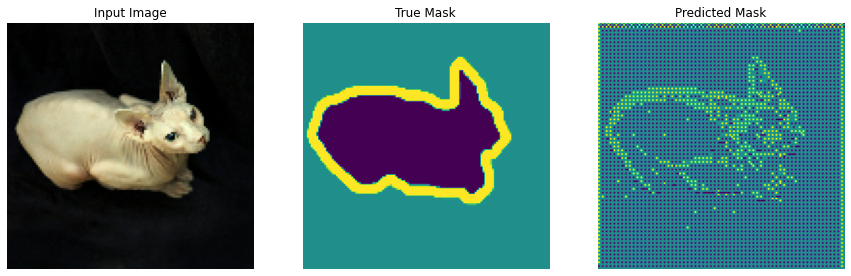

In [ ]:
show_predictions()

## Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below. 

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

**Using FDL Dataset**

In [1]:
# !pip install -q git+https://github.com/tensorflow/examples.git
# !pip install -U albumentations
# !pip uninstall opencv-python-headless==4.5.5.62 
# !pip install opencv-python-headless==4.1.2.30
!pip install segmentation_models
!pip install tensorflow_addons
from tensorflow_addons.metrics import F1Score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
# from keras.preprocessing.image import array_to_img, img_to_array
# import keras.backend as K
from keras.models import Model
from keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
)

import segmentation_models as sm
focal_loss = sm.losses.CategoricalFocalLoss()

import matplotlib.pyplot as plt
from google.colab import drive
import os
import numpy as np
from PIL import Image
import cv2
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, Transpose, RandomRotate90, 
    Rotate, RandomScale, RandomCrop
)

AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 256
INPUT_SIZE = (IMG_SIZE, IMG_SIZE)
BATCH_SIZE = 16
IMG_CHANNELS = 3
NUM_CLASSES = 25

Segmentation Models: using `keras` framework.


In [2]:
!pip install gputil

import GPUtil as GPU
import psutil
import humanize
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available),
          "| Process size: " + humanize.naturalsize( process.memory_info().rss))
    print(f"GPU RAM Free: {gpu.memoryFree:.0f} MB | Used: {gpu.memoryUsed:.0f} MB |"\
          f" Util{gpu.memoryUtil*100:3.0f}% | Total {gpu.memoryTotal:.0f} MB")

printm()

Gen RAM Free: 25.8 GB | Process size: 539.7 MB
GPU RAM Free: 16280 MB | Used: 0 MB | Util  0% | Total 16280 MB


In [3]:
transforms = Compose([
            # RandomRotate90(p=1),
            Rotate(limit=180, interpolation=cv2.INTER_NEAREST, p=1),
            RandomScale(scale_limit=0.2, interpolation=cv2.INTER_NEAREST, p=0.5),
            VerticalFlip(p=0.5),
            HorizontalFlip(p=0.5),
            Transpose(p=0.5),
            RandomCrop(IMG_SIZE, IMG_SIZE, p=1),
        ])

In [4]:
def augment_instance(image, mask):
    data = {"image": image, "mask": mask}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_mask = aug_data["mask"]
    return aug_img, aug_mask

In [ ]:
drive.mount('/content/drive/')
# !unzip "drive/MyDrive/fdl21-fdl-dsba.zip" -d "/content" > /dev/null
os.listdir()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


['.config',
 'test_images',
 'drive',
 'train_images',
 'prepare_submission.py',
 'train_masks',
 'sample_data']

In [ ]:
# image_path = "train_images/train_images/"
# mask_path = "train_masks/train_masks/"

# print(os.listdir(image_path)[:5])
# print(os.listdir(mask_path)[:5])

['7677.jpg', '6799.jpg', '7426.jpg', '7298.jpg', '9459.jpg']
['8351.png', '6659.png', '8440.png', '7306.png', '8909.png']


In [ ]:
# image_names = os.listdir(image_path)
# train_images = []
# train_masks = []

# for image_name in image_names:
#     train_image = Image.open(image_path + image_name)
#     train_image = np.array(train_image.resize(INPUT_SIZE, resample=Image.LANCZOS))
#     train_images.append(train_image)

#     mask_name = image_name.replace(".jpg", ".png")
#     train_mask = Image.open(mask_path + mask_name)
#     train_mask = np.array(train_mask.resize(INPUT_SIZE, resample=Image.NEAREST))
#     train_masks.append(train_mask)

# train_images = np.array(train_images, dtype="float")
# train_images /= 255
# train_masks = np.array(train_masks)
# train_masks = np.where(train_masks <= 24, train_masks, 0)

In [ ]:
# print(train_images.shape)
# print(train_masks.shape)

(261, 256, 256, 3)
(261, 256, 256)


In [5]:
# with open('drive/MyDrive/train_256.npy', 'wb') as f:
#     np.save(f, train_images)
#     np.save(f, train_masks)

with open('drive/MyDrive/train_512.npy', 'rb') as f:
    train_images = np.load(f)
    train_masks = np.load(f)

print(train_images.shape)
print(train_masks.shape)

(261, 512, 512, 3)
(261, 512, 512)


In [6]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self, x_data, y_data, batch_size, is_train):
    self.x, self.y = x_data, y_data
    self.batch_size = batch_size
    self.num_batches = np.ceil(len(x_data) / batch_size)
    self.batch_idx = np.array_split(range(len(x_data)), self.num_batches)
    self.is_train = is_train

  def __len__(self):
    return len(self.batch_idx)

  def __getitem__(self, idx):
    batch_x = self.x[self.batch_idx[idx]]
    batch_y = self.y[self.batch_idx[idx]]
    if not self.is_train:
        firt_quarter_x = batch_x[:, :IMG_SIZE, :IMG_SIZE, :]
        second_quarter_x = batch_x[:, :IMG_SIZE, IMG_SIZE:, :]
        third_quarter_x = batch_x[:, IMG_SIZE:, :IMG_SIZE, :]
        fourth_quarter_x = batch_x[:, IMG_SIZE:, IMG_SIZE:, :]
        batch_x_new = np.concatenate([firt_quarter_x, second_quarter_x,
                                      third_quarter_x, fourth_quarter_x])

        first_quarter_y = batch_y[:, :IMG_SIZE, :IMG_SIZE]
        second_quarter_y =batch_y[:, :IMG_SIZE, IMG_SIZE:]
        third_quarter_y = batch_y[:, IMG_SIZE:, :IMG_SIZE]
        fourth_quarter_y = batch_y[:, IMG_SIZE:, IMG_SIZE:]
        batch_y_new = np.concatenate([first_quarter_y, second_quarter_y,
                                      third_quarter_y, fourth_quarter_y])

        batch_y_new = to_categorical(batch_y_new, num_classes=NUM_CLASSES)
        return batch_x_new, batch_y_new

    num_samples = batch_x.shape[0]
    batch_x_new = np.empty((num_samples, IMG_SIZE, IMG_SIZE, IMG_CHANNELS))
    batch_y_new = np.empty((num_samples, IMG_SIZE, IMG_SIZE))
    for i in range(batch_x_new.shape[0]):
        image = batch_x[i, :, :, :]
        mask = batch_y[i, :, :]
        image, mask = augment_instance(image, mask)
        batch_x_new[i, :, :, :] = image
        batch_y_new[i, :, :] = mask

    batch_y_new = to_categorical(batch_y_new, num_classes=NUM_CLASSES)
    return batch_x_new, batch_y_new

In [ ]:
# train_masks_cat = to_categorical(train_masks, num_classes=n_classes)
# print(train_masks.shape)
# print(train_masks_cat.shape)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    train_images, train_masks, test_size = 0.20, random_state = 42)

full_generator = DataGenerator(
    train_images, train_masks, BATCH_SIZE, True)
train_generator = DataGenerator(
    X_train, y_train, BATCH_SIZE, True)
valid_generator = DataGenerator(
    X_valid, y_valid, BATCH_SIZE, False)

In [8]:
image_batch, mask_batch = next(iter(train_generator))
print(image_batch.shape)
print(mask_batch.shape)
first_image = image_batch[0, :, :, :]
first_mask = mask_batch[0, :, :]
print(first_image.shape)
print(first_mask.shape)

(16, 256, 256, 3)
(16, 256, 256, 25)
(256, 256, 3)
(256, 256, 25)


In [9]:
image_batch, mask_batch = next(iter(valid_generator))
print(image_batch.shape)
print(mask_batch.shape)
first_image = image_batch[0, :, :, :]
first_mask = mask_batch[0, :, :]
print(first_image.shape)
print(first_mask.shape)

(56, 256, 256, 3)
(56, 256, 256, 25)
(256, 256, 3)
(256, 256, 25)


In [ ]:
mask1 = Image.open("/content/train_masks/train_masks/6412.png")
print(np.unique(np.array(mask1)))
mask = mask1.resize((512, 512), resample=Image.LANCZOS)
print(np.unique(np.array(mask)))
mask = mask1.resize((512, 512), resample=Image.BICUBIC)
print(np.unique(np.array(mask)))
mask = mask1.resize((512, 512), resample=Image.NEAREST)
print(np.unique(np.array(mask)))

[ 0  1  2  3  4  5  6  8 12 14]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[ 0  1  2  3  4  5  6  8 12 14]


In [10]:
def draw_image_mask(image, mask):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(image)

    if mask.shape[-1] == 25:
        mask_new = mask.argmax(axis=-1)
    else:
        mask_new = mask
    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask_new, cmap="gray")
    plt.axis('off')
    plt.show()

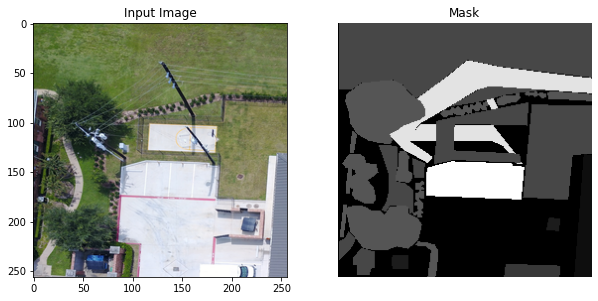

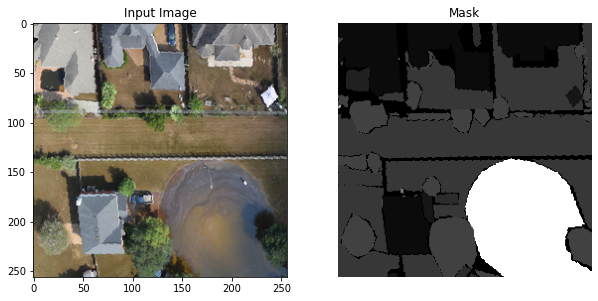

In [11]:
draw_image_mask(first_image, first_mask)
image_batch, mask_batch = next(iter(train_generator))
first_image = image_batch[0, :, :, :]
first_mask = mask_batch[0, :, :]
draw_image_mask(first_image, first_mask)

In [ ]:
for i in range(10):
    current_image = train_images[i]
    current_mask = train_masks[i]
    draw_image_mask(current_image, current_mask)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(np.unique(train_masks))
print("number of classes is", len(np.unique(train_masks)))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
number of classes is 25


In [ ]:
first_image[0][0]

array([0.58431373, 0.54117647, 0.40392157])

In [12]:
def multi_unet_model(n_classes=25, img_height=256, img_width=256, img_channels=3):
    inputs = Input((img_height, img_width, img_channels))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this because it's normalized beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight
# weights = compute_class_weight(class_weight="balanced", 
#                                classes=np.unique(np.ravel(train_masks,order='C')),
#                                y=np.ravel(train_masks,order='C'))

In [ ]:
# # weights_new = np.sqrt(weights)
# weights_new = np.log(weights+1)

In [ ]:
# dice_loss = sm.losses.DiceLoss(class_weights=weights_new) 
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

In [13]:
train_steps = int(np.ceil(len(X_train) / BATCH_SIZE))
valid_steps = int(np.ceil(len(X_valid) / BATCH_SIZE))
print(train_steps)
print(valid_steps)
train_steps_full = int(np.ceil(len(train_images) / BATCH_SIZE))
print(train_steps_full)

13
4
17


In [ ]:
EPOCHS = 400

model = multi_unet_model(NUM_CLASSES, IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
model.compile(optimizer='adam',
              # loss='categorical_crossentropy',
              # loss=total_loss,
              loss=focal_loss,
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=train_steps,
                    verbose=2,
                    epochs=EPOCHS,
                    validation_data=valid_generator,
                    validation_steps=valid_steps,
                    shuffle=True)

Epoch 1/400
13/13 - 6s - loss: 0.0249 - accuracy: 0.2536 - val_loss: 0.0214 - val_accuracy: 0.3153 - 6s/epoch - 493ms/step
Epoch 2/400
13/13 - 4s - loss: 0.0196 - accuracy: 0.2806 - val_loss: 0.0187 - val_accuracy: 0.2578 - 4s/epoch - 302ms/step
Epoch 3/400
13/13 - 4s - loss: 0.0175 - accuracy: 0.2812 - val_loss: 0.0176 - val_accuracy: 0.3367 - 4s/epoch - 304ms/step
Epoch 4/400
13/13 - 4s - loss: 0.0151 - accuracy: 0.3170 - val_loss: 0.0155 - val_accuracy: 0.3664 - 4s/epoch - 304ms/step
Epoch 5/400
13/13 - 4s - loss: 0.0137 - accuracy: 0.3435 - val_loss: 0.0153 - val_accuracy: 0.3736 - 4s/epoch - 306ms/step
Epoch 6/400
13/13 - 4s - loss: 0.0129 - accuracy: 0.3642 - val_loss: 0.0142 - val_accuracy: 0.3845 - 4s/epoch - 305ms/step
Epoch 7/400
13/13 - 4s - loss: 0.0125 - accuracy: 0.3693 - val_loss: 0.0143 - val_accuracy: 0.3862 - 4s/epoch - 300ms/step
Epoch 8/400
13/13 - 4s - loss: 0.0118 - accuracy: 0.3798 - val_loss: 0.0142 - val_accuracy: 0.3567 - 4s/epoch - 303ms/step
Epoch 9/400
13/1

In [14]:
def plot_loss_accuracies(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(EPOCHS)
    plt.figure(figsize = (10, 8))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'bo', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.show()

    loss = history.history['accuracy']
    val_loss = history.history['val_accuracy']
    epochs = range(EPOCHS)
    plt.figure(figsize = (10, 8)) 
    plt.plot(epochs, loss, 'r', label='Training accuracy')
    plt.plot(epochs, val_loss, 'bo', label='Validation accuracy')
    plt.title('Training and Validation Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.show()

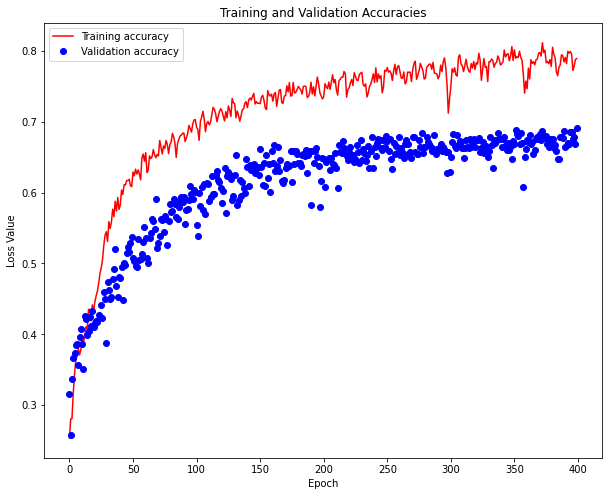

In [ ]:
plot_loss_accuracies(history)

In [16]:
# del history, X_train, y_train, X_valid, y_valid
model = multi_unet_model(NUM_CLASSES, IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
model.compile(optimizer='adam',
              # loss='categorical_crossentropy',
              # loss=total_loss,
              loss=focal_loss,
              metrics=['accuracy'])

history = model.fit(full_generator,
                    steps_per_epoch=train_steps_full,
                    verbose=2,
                    epochs=600,
                    shuffle=True)

Epoch 1/600
17/17 - 8s - loss: 0.0270 - accuracy: 0.1445 - 8s/epoch - 451ms/step
Epoch 2/600
17/17 - 3s - loss: 0.0213 - accuracy: 0.2934 - 3s/epoch - 188ms/step
Epoch 3/600
17/17 - 3s - loss: 0.0188 - accuracy: 0.2922 - 3s/epoch - 188ms/step
Epoch 4/600
17/17 - 3s - loss: 0.0169 - accuracy: 0.2910 - 3s/epoch - 191ms/step
Epoch 5/600
17/17 - 3s - loss: 0.0154 - accuracy: 0.3214 - 3s/epoch - 182ms/step
Epoch 6/600
17/17 - 3s - loss: 0.0138 - accuracy: 0.3605 - 3s/epoch - 185ms/step
Epoch 7/600
17/17 - 3s - loss: 0.0129 - accuracy: 0.3722 - 3s/epoch - 188ms/step
Epoch 8/600
17/17 - 3s - loss: 0.0124 - accuracy: 0.3871 - 3s/epoch - 189ms/step
Epoch 9/600
17/17 - 3s - loss: 0.0124 - accuracy: 0.3788 - 3s/epoch - 186ms/step
Epoch 10/600
17/17 - 3s - loss: 0.0118 - accuracy: 0.3819 - 3s/epoch - 186ms/step
Epoch 11/600
17/17 - 3s - loss: 0.0112 - accuracy: 0.3967 - 3s/epoch - 185ms/step
Epoch 12/600
17/17 - 3s - loss: 0.0112 - accuracy: 0.3999 - 3s/epoch - 187ms/step
Epoch 13/600
17/17 - 3s -

In [17]:
# !unzip "drive/MyDrive/fdl21-fdl-dsba.zip" -d "/content" > /dev/null
test_path = "test_images/test_images/"
test_images = os.listdir(test_path)
tests = []
for image_name in test_images:
    test = Image.open(test_path + image_name)
    test = np.array(test.resize((2*IMG_SIZE, 2*IMG_SIZE), resample=Image.LANCZOS))
    tests.append(test)

tests = np.array(tests, dtype="float")
tests /= 255
print(tests.shape)

firt_quarter_test = tests[:, :IMG_SIZE, :IMG_SIZE, :]
second_quarter_test = tests[:, :IMG_SIZE, IMG_SIZE:, :]
third_quarter_test = tests[:, IMG_SIZE:, :IMG_SIZE, :]
fourth_quarter_x = tests[:, IMG_SIZE:, IMG_SIZE:, :]
tests_new = np.concatenate([firt_quarter_test, second_quarter_test,
                            third_quarter_test, fourth_quarter_x])

del firt_quarter_test, second_quarter_test, third_quarter_test, fourth_quarter_x
print(tests_new.shape)

(112, 512, 512, 3)
(448, 256, 256, 3)


In [18]:
preds = model.predict(tests_new).argmax(axis=-1)
print(tests_new.shape)
print(preds.shape)
print(np.unique(preds))

(448, 256, 256, 3)
(448, 256, 256)
[ 0  1  2  3  4  5  6  8 14 16 18 19 20 21 22 23]


In [19]:
test_size = 112
patches = []
for i in range(4):
    patch_range = range(test_size * i, test_size*(i + 1))
    print(np.min(patch_range), np.max(patch_range))
    patch = preds[patch_range, :, :]
    print(patch.shape)
    patches.append(patch)

firt_test, second_test, third_test, fourth_test = patches
upper_half = np.concatenate([firt_test, second_test], axis=2)
lower_half = np.concatenate([third_test, fourth_test], axis=2)
full_pred = np.concatenate([upper_half, lower_half], axis=1)
del firt_test, second_test, third_test, fourth_test
del upper_half, lower_half
full_pred.shape

0 111
(112, 256, 256)
112 223
(112, 256, 256)
224 335
(112, 256, 256)
336 447
(112, 256, 256)


(112, 512, 512)

In [20]:
print("the number of predicted labels", len(np.unique(full_pred)))

the number of predicted labels 16


In [21]:
pred_path = "data/test_preds/"
does_exist = os.path.exists(pred_path)
if not does_exist:
    os.makedirs(pred_path)
    print("The new directory is created!")

In [22]:
for i in range(test_size):
    image_name = test_images[i]
    mask_name = test_images[i][:-4] + ".png"
    image = tests[i]
    mask = Image.fromarray(full_pred[i].astype(np.uint8))
    mask.save(pred_path + mask_name)
    if i < 10:
      draw_image_mask(image, full_pred[i])

Output hidden; open in https://colab.research.google.com to view.

In [23]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def create_rles():
    """Used for Kaggle submission: predicts and encode all test images"""
    dir = 'data/test_preds/'
    N = len(list(os.listdir(dir)))
    with open('drive/MyDrive/submission_file.csv', 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        for index, i in enumerate(os.listdir(dir)):
            # print('{}/{}'.format(index, N))
            d = dir + i
            if d == "data/test_preds/.ipynb_checkpoints": pass
            else:
              mask = Image.open(dir + i)
              mask = mask.resize((1024, 1024), resample=Image.NEAREST)
              mask = np.array(mask)

              for x in range(1, 25):
                  enc = rle_encode(mask == x)
                  f.write(f"{i.split('_')[0]}_{x},{enc}\n")

In [24]:
create_rles()

In [7]:
transforms1 = Compose([
            # RandomRotate90(p=1),
            Rotate(limit=180, interpolation=cv2.INTER_NEAREST, p=1),
            # RandomScale(scale_limit=0.15, interpolation=cv2.INTER_NEAREST, p=0.5),
            VerticalFlip(p=0.5),
            HorizontalFlip(p=0.5),
            Transpose(p=0.5),
            # RandomCrop(IMG_SIZE, IMG_SIZE, p=1),
        ])

def augment_instance1(image, mask):
    data = {"image": image, "mask": mask}
    aug_data = transforms1(**data)
    aug_img = aug_data["image"]
    aug_mask = aug_data["mask"]
    return aug_img, aug_mask

In [16]:
def multi_unet_model(n_classes=25, img_height=256, img_width=256, img_channels=3):
    inputs = Input((img_height, img_width, img_channels))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this because it's normalized beforehand
    s = inputs

    #Contraction path
    c0 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c0 = Dropout(0.1)(c0)  # Original 0.1
    c0 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c0)
    p0 = MaxPooling2D((2, 2))(c0)

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p0)
    c1 = Dropout(0.1)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    u10 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c0], axis=3)
    c10 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = Dropout(0.1)(c10)  # Original 0.1
    c10 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c10)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [17]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x_data, y_data, batch_size, is_train):
        self.x, self.y = x_data, y_data
        self.batch_size = batch_size
        self.num_batches = np.ceil(len(x_data) / batch_size)
        self.batch_idx = np.array_split(range(len(x_data)), self.num_batches)
        self.is_train = is_train

    def __len__(self):
        return len(self.batch_idx)

    def __getitem__(self, idx):
        batch_x = self.x[self.batch_idx[idx]]
        batch_y = self.y[self.batch_idx[idx]]
        if not self.is_train:
            batch_y_new = to_categorical(batch_y, num_classes=NUM_CLASSES)
            return batch_x, batch_y_new

        batch_x_new = np.empty_like(batch_x)
        batch_y_new = np.empty_like(batch_y)
        for i in range(batch_x_new.shape[0]):
            image = batch_x[i, :, :, :]
            mask = batch_y[i, :, :]
            image, mask = augment_instance1(image, mask)
            batch_x_new[i, :, :, :] = image
            batch_y_new[i, :, :] = mask

        batch_y_new = to_categorical(batch_y_new, num_classes=NUM_CLASSES)
        return batch_x_new, batch_y_new

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    train_images, train_masks, test_size = 0.20, random_state = 42)

full_generator = DataGenerator(
    train_images, train_masks, BATCH_SIZE, True)
train_generator = DataGenerator(
    X_train, y_train, BATCH_SIZE, True)
valid_generator = DataGenerator(
    X_valid, y_valid, BATCH_SIZE, False)

In [19]:
image_batch, mask_batch = next(iter(train_generator))
print(image_batch.shape)
print(mask_batch.shape)
first_image = image_batch[0, :, :, :]
first_mask = mask_batch[0, :, :]
print(first_image.shape)
print(first_mask.shape)

(16, 512, 512, 3)
(16, 512, 512, 25)
(512, 512, 3)
(512, 512, 25)


In [20]:
image_batch, mask_batch = next(iter(valid_generator))
print(image_batch.shape)
print(mask_batch.shape)
first_image = image_batch[0, :, :, :]
first_mask = mask_batch[0, :, :]
print(first_image.shape)
print(first_mask.shape)

(14, 512, 512, 3)
(14, 512, 512, 25)
(512, 512, 3)
(512, 512, 25)


In [24]:
train_steps = int(np.ceil(len(X_train) / BATCH_SIZE))
valid_steps = int(np.ceil(len(X_valid) / BATCH_SIZE))
print(train_steps)
print(valid_steps)
train_steps_full = int(np.ceil(len(train_images) / BATCH_SIZE))
print(train_steps_full)

13
4
17


In [27]:
EPOCHS = 400
model = multi_unet_model(NUM_CLASSES, 2*IMG_SIZE, 2*IMG_SIZE, IMG_CHANNELS)
model.compile(optimizer='adam',
              # loss='categorical_crossentropy',
              # loss=total_loss,
              loss=focal_loss,
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=train_steps,
                    verbose=2,
                    epochs=EPOCHS,
                    validation_data=valid_generator,
                    validation_steps=valid_steps,
                    shuffle=True)

Epoch 1/400
13/13 - 9s - loss: 0.0301 - accuracy: 0.0138 - val_loss: 0.0296 - val_accuracy: 0.0207 - 9s/epoch - 677ms/step
Epoch 2/400
13/13 - 7s - loss: 0.0294 - accuracy: 0.0829 - val_loss: 0.0292 - val_accuracy: 0.1000 - 7s/epoch - 510ms/step
Epoch 3/400
13/13 - 7s - loss: 0.0290 - accuracy: 0.0934 - val_loss: 0.0286 - val_accuracy: 0.0762 - 7s/epoch - 540ms/step
Epoch 4/400
13/13 - 7s - loss: 0.0280 - accuracy: 0.0464 - val_loss: 0.0272 - val_accuracy: 0.0015 - 7s/epoch - 536ms/step
Epoch 5/400
13/13 - 7s - loss: 0.0266 - accuracy: 0.0038 - val_loss: 0.0257 - val_accuracy: 0.0019 - 7s/epoch - 536ms/step
Epoch 6/400
13/13 - 7s - loss: 0.0249 - accuracy: 0.0598 - val_loss: 0.0239 - val_accuracy: 0.0930 - 7s/epoch - 534ms/step
Epoch 7/400
13/13 - 7s - loss: 0.0227 - accuracy: 0.1907 - val_loss: 0.0209 - val_accuracy: 0.3241 - 7s/epoch - 533ms/step
Epoch 8/400
13/13 - 7s - loss: 0.0196 - accuracy: 0.3038 - val_loss: 0.0177 - val_accuracy: 0.3567 - 7s/epoch - 539ms/step
Epoch 9/400
13/1

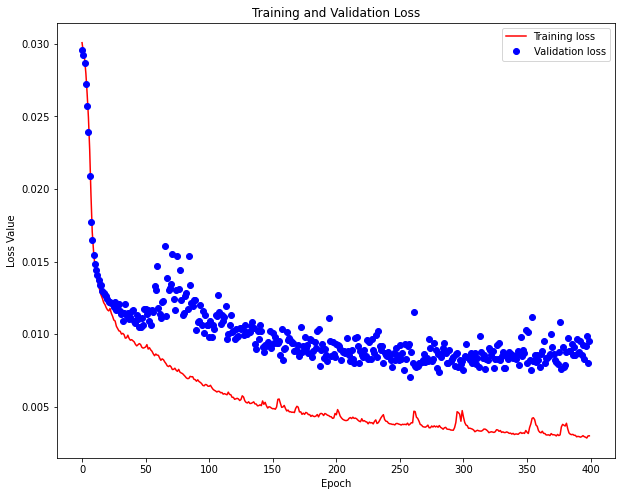

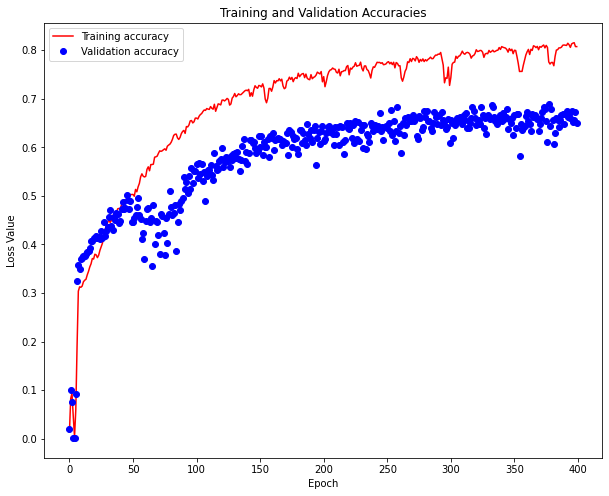

In [28]:
plot_loss_accuracies(history)

In [ ]:
# del history, X_train, y_train, X_valid, y_valid
model = multi_unet_model(NUM_CLASSES, 2*IMG_SIZE, 2*IMG_SIZE, IMG_CHANNELS)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              # loss=total_loss,
              # loss=focal_loss,
              metrics=['accuracy'])

history = model.fit(full_generator,
                    steps_per_epoch=train_steps_full,
                    verbose=2,
                    epochs=EPOCHS,
                    shuffle=True)

Epoch 1/400
17/17 - 9s - loss: 3.0662 - accuracy: 0.1260 - 9s/epoch - 531ms/step
Epoch 2/400
17/17 - 7s - loss: 2.7439 - accuracy: 0.1634 - 7s/epoch - 429ms/step
Epoch 3/400
17/17 - 7s - loss: 2.5221 - accuracy: 0.2288 - 7s/epoch - 435ms/step
Epoch 4/400
17/17 - 7s - loss: 2.3657 - accuracy: 0.2813 - 7s/epoch - 432ms/step
Epoch 5/400
17/17 - 7s - loss: 2.2564 - accuracy: 0.2857 - 7s/epoch - 438ms/step
Epoch 6/400
17/17 - 7s - loss: 2.1902 - accuracy: 0.2838 - 7s/epoch - 436ms/step
Epoch 7/400
17/17 - 7s - loss: 2.1293 - accuracy: 0.2861 - 7s/epoch - 435ms/step
Epoch 8/400
17/17 - 7s - loss: 2.0744 - accuracy: 0.2842 - 7s/epoch - 427ms/step
Epoch 9/400
17/17 - 7s - loss: 2.0436 - accuracy: 0.2846 - 7s/epoch - 433ms/step
Epoch 10/400
17/17 - 7s - loss: 1.9994 - accuracy: 0.2864 - 7s/epoch - 430ms/step
Epoch 11/400
17/17 - 8s - loss: 1.9713 - accuracy: 0.2871 - 8s/epoch - 442ms/step
Epoch 12/400
17/17 - 7s - loss: 1.9530 - accuracy: 0.2885 - 7s/epoch - 435ms/step
Epoch 13/400
17/17 - 7s -

In [ ]:
pred_path = "data/test_preds/"
does_exist = os.path.exists(pred_path)
if not does_exist:
    os.makedirs(pred_path)
    print("The new directory is created!")

In [62]:
# !unzip "drive/MyDrive/fdl21-fdl-dsba.zip" -d "/content" > /dev/null
test_path = "test_images/test_images/"
test_images = os.listdir(test_path)
tests = []
predicted_labels_count = set()
for i, image_name in enumerate(test_images):
    test = Image.open(test_path + image_name)
    test = np.array(
        test.resize((2*IMG_SIZE, 2*IMG_SIZE), resample=Image.LANCZOS),
        dtype="float")
    test /= 255
    test_image = np.expand_dims(test, 0)

    mask_name = image_name[:-4] + ".png"
    pred_mask = model.predict(test_image).argmax(axis=-1)
    pred_mask = pred_mask[0].astype(np.uint8)
    mask = Image.fromarray(pred_mask)
    mask.save(pred_path + mask_name)
    predicted_labels_count.update(np.unique(pred_mask))
    if i < 10:
        draw_image_mask(test, pred_mask)

Output hidden; open in https://colab.research.google.com to view.

In [63]:
create_rles()
print("Submission file created!")
print("Number of labels", len(predicted_labels_count))

Submission file created!
Number of labels 12
